## Simple MTBD with moment-mediated mean-field interaction

In [1]:
import jax
import jax.numpy as jnp
import diffrax as dx
import jaxopt
import matplotlib.pyplot as plt

jax.config.update("jax_enable_x64", True)

Type number

In [2]:
d = 5

Particle-wise birth and death rates

In [3]:
λ = 1.0 * jnp.ones(d)
λ = λ.at[0].mul(2)
λ

Array([2., 1., 1., 1., 1.], dtype=float64)

In [4]:
μ = 0.1 * jnp.ones(d)
μ

Array([0.1, 0.1, 0.1, 0.1, 0.1], dtype=float64)

Type transition rate matrix

In [5]:
Γ = jax.scipy.linalg.toeplitz(jnp.exp(-1.0 * jnp.arange(d)))
Γ = Γ.at[jnp.arange(d), jnp.arange(d)].set(0)
Γ = Γ.at[jnp.arange(d), jnp.arange(d)].set(-Γ.sum(1))

Plot $\lambda$, $\mu$, and $\Gamma$

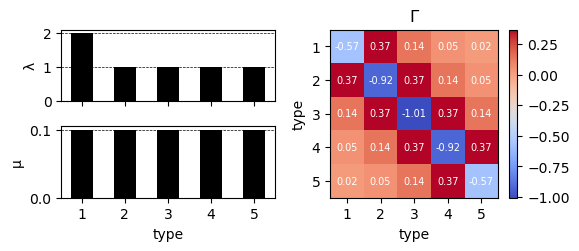

In [6]:
fig = plt.figure(figsize=(6, 2.5))

ax0 = plt.subplot2grid((2, 2), (0, 0))  # for ax[0]
ax1 = plt.subplot2grid((2, 2), (1, 0))  # for ax[1]
ax2 = plt.subplot2grid((2, 2), (0, 1), rowspan=2)  # for ax[2]

type_names = range(1, d + 1)

ax0.bar(type_names, λ, color="k", width=0.5)
ax0.set_xticklabels([])
ax0.set_yticks([0, 1, 2])
ax0.axhline(1, color="k", linestyle="--", linewidth=0.5)
ax0.axhline(2, color="k", linestyle="--", linewidth=0.5)
ax0.set_ylabel("λ")

ax1.bar(type_names, μ, color="k", width=0.5)
ax1.axhline(0.1, color="k", linestyle="--", linewidth=0.5)
ax1.set_xticks(type_names)
ax1.set_xlabel("type")
ax1.set_ylabel("μ")

cmap = ax2.imshow(Γ, cmap="coolwarm")
ax2.set_xticks(range(d))
ax2.set_xticklabels(type_names)
ax2.set_yticks(range(d))
ax2.set_yticklabels(type_names)
ax2.set_xlabel("type")
ax2.set_ylabel("type")
ax2.set_title("Γ")

for i in range(d):
    for j in range(d):
        text = ax2.text(j, i, f"{Γ[i, j]:.2f}",
                       ha="center", va="center", color="w", size=7)

cmap = fig.colorbar(cmap, ax=ax2, shrink=1.0)

plt.tight_layout()
plt.savefig("output/params.pdf")
plt.show()


Weights on the death rate modulator

In [7]:
# interaction_type = "free"
interaction_type = "capacity"
# interaction_type = "nfds"
# interaction_type = "pfds"

match interaction_type:
    case "free":
        W = jnp.zeros((d, d))
    case "capacity":
        W = jnp.ones((d, d))
    case "nfds":
        W = jnp.eye(d)
    case "pfds":
        W = (jnp.ones((d, d)) - 0.6 * jnp.eye(d))
    case _:
        raise ValueError(f"Unknown interaction type {interaction_type}")

if interaction_type != "free":
    W = 0.01 * W / jnp.linalg.norm(W)

W

Array([[0.002, 0.002, 0.002, 0.002, 0.002],
       [0.002, 0.002, 0.002, 0.002, 0.002],
       [0.002, 0.002, 0.002, 0.002, 0.002],
       [0.002, 0.002, 0.002, 0.002, 0.002],
       [0.002, 0.002, 0.002, 0.002, 0.002]], dtype=float64)

We model the process on the interval $[0,\tau]$.

In [8]:
τ = 10.0

We'll take the stationary state of the type transition rate matrix as the initial condition $\mathbf{r}_0$.

In [9]:
M_aug = jnp.vstack((Γ.T[:-1], jnp.ones(d)))
b = jnp.concatenate((jnp.zeros(d - 1), jnp.array([1])))
r0 = jnp.linalg.solve(M_aug, b)
r0

Array([0.2, 0.2, 0.2, 0.2, 0.2], dtype=float64)

In [10]:
@jax.jit
def f(t, r, φ):
    return (jnp.diag(λ - (μ + W @ r)) + Γ) @ r

We'll use the solution of the free system (without mean-field interaction) for the initial field trajectory.

The transcendental equation for the critical field

In [11]:
def criticality(φ):
    return (jnp.diag(λ - (μ + W @ φ)) + Γ) @ φ

In [12]:
time_grid = jnp.linspace(0.0, τ, 1000)

In [13]:
solver = dx.Dopri8()
stepsize_controller = dx.PIDController(rtol=1e-8, atol=1e-8)

In [14]:
dx.citation(solver=solver, stepsize_controller=stepsize_controller)


% --- AUTOGENERATED REFERENCES PRODUCED USING `diffrax.citation(...)` ---
% The following references were found for the numerical techniques being used.
% This does not cover e.g. any modelling techniques being used.
% If you think a paper is missing from here then open an issue or pull request at
% https://github.com/patrick-kidger/diffrax

% You are using Diffrax, which is citable as:
phdthesis{kidger2021on,
    title={{O}n {N}eural {D}ifferential {E}quations},
    author={Patrick Kidger},
    year={2021},
    school={University of Oxford},
}

% You are using Equinox, which is citable as:
@article{kidger2021equinox,
    author={Patrick Kidger and Cristian Garcia},
    title={{E}quinox: neural networks in {JAX} via callable {P}y{T}rees and
           filtered transformations},
    year={2021},
    journal={Differentiable Programming workshop at Neural Information Processing
             Systems 2021}
}

% You are using JAX, which is citable as:
@software{jax2018github,
  author = {Jam

In [15]:
sol = dx.diffeqsolve(dx.ODETerm(f),
                      solver,
                      0.0,
                      τ,
                      1e-3 * τ,
                      r0,
                      saveat=dx.SaveAt(dense=True),
                      stepsize_controller=stepsize_controller,
                      max_steps=100000)

critical_solver = jaxopt.ScipyRootFinding(method="hybr", optimality_fun=criticality)
φ_critical, state = critical_solver.run(sol.evaluate(τ))
assert state.success

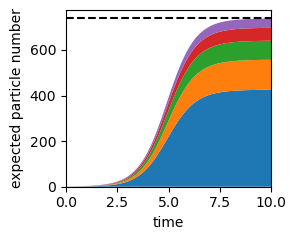

In [16]:
if interaction_type == "free":
    plt.figure(figsize=(2.5, 2.5))
    plt.plot(time_grid, jax.vmap(sol.evaluate)(time_grid))
    plt.yscale("log")
else:
    plt.figure(figsize=(3, 2.5))
    plt.stackplot(time_grid, jax.vmap(sol.evaluate)(time_grid).T)
    plt.axhline(φ_critical.sum(), color="black", ls="--")
    plt.ylim(0, 1.05 * φ_critical.sum())
plt.xlabel("time")
plt.ylabel("expected particle number")
plt.xlim(0, τ)

plt.tight_layout()
plt.savefig(f"output/{interaction_type}.pdf")
plt.show()